In [1]:
%matplotlib inline

import seaborn as sns
sns.set_color_codes()

### Observational Data
Discuss where to download etc and stations

In [2]:
import gzip
from io import BytesIO
from ish_parser import ish_parser

def read_observations(years, usaf='081810', wban='99999'):
    parser = ish_parser()
    
    for year in years:
        path = "data/observations/{usaf}-{wban}-{year}.gz".format(year=year, usaf=usaf, wban=wban)
        with gzip.open(path) as gz:
            parser.loads(bytes.decode(gz.read()))
            
    reports = parser.get_reports()
    
    station_latitudes = [41.283, 41.293] 
    observations = pd.DataFrame.from_records(((r.datetime, 
                                               r.air_temperature.get_numeric(),
                                               (r.precipitation[0]['depth'].get_numeric() if r.precipitation else 0),
                                               r.humidity.get_numeric(),
                                               r.sea_level_pressure.get_numeric(),
                                               r.wind_speed.get_numeric(),
                                               r.wind_direction.get_numeric()) 
                                              for r in reports if r.latitude in station_latitudes and r.datetime.minute == 0),
                             columns=['timestamp', 'AT', 'precipitation', 'humidity', 'pressure', 'wind_speed', 'wind_direction'], 
                             index='timestamp')
    
    observations = observations[['AT', 'precipitation', 
                             'humidity', 'pressure', 
                             'wind_speed']]
    
    return observations


### Numerical Weather Model Predictions - NEMS4
Discuss where to download etc and stations, prediction horizon etc

In [3]:
import json
import pandas as pd
import numpy as np

def read_nems4(years, prediction_hours=12):
    predictions=pd.DataFrame()
    for year in years:
        with open('data/NEMS4/{}.json'.format(year)) as json_data:
            d = json.load(json_data)
            if not predictions.empty:
                predictions = predictions.append( pd.DataFrame(d['history_1h']))
            else:
                predictions = pd.DataFrame(d['history_1h'])

    predictions = predictions.set_index('time')
    predictions.index.name = 'timestamp'
    
    # shift dataset back 12 hours as its a the value is the prediction for the given timestmap 12 hours previously
    predictions.index = pd.to_datetime(predictions.index) - pd.Timedelta(hours=12)
    predictions.index.tz = 'UTC'

    predictions = predictions[['temperature', 'precipitation', 
                   'relativehumidity', 'sealevelpressure', 
                   'windspeed']]
    
    predictions = predictions.rename(columns={
        'windspeed': 'nems4_wind_speed', 
        'temperature': 'nems4_AT',
        'precipitation': 'nems4_precipitation',
        'relativehumidity': 'nems4_humidity',
        'sealevelpressure': 'nems4_pressure'})
    
    return predictions


In [4]:
years = range(2010, 2015)
dataset = pd.merge(read_observations(years), read_nems4(years), left_index=True, right_index=True, how='inner')

original = dataset.copy(deep=True)
dataset.describe()

,AT,precipitation,humidity,pressure,wind_speed,nems4_AT,nems4_precipitation,nems4_humidity,nems4_pressure,nems4_wind_speed
count,43177.000000,43130.000000,43162.000000,35117.000000,43213.000000,43217.000000,43217.000000,43217.000000,43217.000000,43217.000000
mean,16.911279,0.084672,68.819865,1016.236418,4.076880,16.149210,0.037606,71.680380,1015.828378,3.464177
std,6.829713,1.083148,14.874102,6.826032,2.096274,6.763601,0.272675,15.757395,7.093197,2.032260
min,-3.500000,0.000000,8.000000,980.200000,0.000000,-5.840000,0.000000,12.000000,982.000000,0.000000
25%,11.800000,0.000000,60.000000,1012.500000,2.600000,11.130000,0.000000,61.000000,1012.000000,1.930000
50%,16.800000,0.000000,70.000000,1016.700000,3.600000,16.410000,0.000000,73.000000,1016.000000,3.090000
75%,22.600000,0.000000,79.000000,1020.300000,5.100000,21.400000,0.000000,84.000000,1020.000000,4.640000
max,35.300000,56.000000,100.000000,1038.700000,17.000000,39.210000,16.000000,100.000000,1037.000000,22.320000


### Transformations - Preprocessing

In [25]:
def drop_duplicates(df):
    print("Number of duplicates: {}".format(len(df.index.get_duplicates())))
    return df[~df.index.duplicated(keep='first')]
    
def impute_missing(df):
    # todo test with moving average / mean or something smarter than forward fill
    print("Number of rows with nan: {}".format(np.count_nonzero(df.isnull())))
    df.fillna(method='ffill', inplace=True)
    return df
    
def first_order_difference(data, columns):
    for column in columns:
        data[column+'_d'] = data[column].diff(periods=1)
    
    return data.dropna()

pd.options.mode.chained_assignment = None  # default='warn'
def derive_prediction_columns(data, column, horizons):
    # get prediction - (i.e. change between now and lookahead) and shift back lookahead
    
    for look_ahead in horizons:
        data['prediction_' + str(look_ahead)] = data[column].diff(periods=look_ahead).shift(-look_ahead)
    
    return data.dropna()

def select_features(df):
    return df[['wind_speed', 
                    'nems4_wind_speed', 
                    'AT', 
                    'nems4_AT', 
                    'humidity', 
                    'nems4_humidity',
                    'pressure',
                    'nems4_pressure']]


from sklearn import preprocessing

def scale_features(scaler, features):
    scaler.fit(features)
    
    scaled = scaler.transform(features)
    scaled = pd.DataFrame(scaled, columns=features.columns)
    
    return scaled

def inverse_scale_prediction(scaler, predictions, original_columns, original_column_loc):
    inverted = np.zeros((len(predictions), original_columns))
    inverted[:,original_column_loc] = np.reshape(predictions, (predictions.shape[0],))
    
    inverted = scaler.inverse_transform(inverted)[:,original_column_loc]
    
    return inverted

def inverse_prediction_difference(predictions, original):
    return predictions + original

In [6]:
dataset = drop_duplicates(dataset)
dataset = impute_missing(dataset)

features = select_features(dataset)

horizons = [1, 12]
features = first_order_difference(features, features.columns)
features = derive_prediction_columns(features, 'wind_speed', horizons)

scaler = preprocessing.StandardScaler()#.MinMaxScaler(feature_range=(-1, 1)) 
scaled = scale_features(scaler, features)

scaled.describe()

Number of duplicates: 95
Number of rows with nan: 8270


,wind_speed,nems4_wind_speed,AT,nems4_AT,humidity,nems4_humidity,pressure,nems4_pressure,wind_speed_d,nems4_wind_speed_d,AT_d,nems4_AT_d,humidity_d,nems4_humidity_d,pressure_d,nems4_pressure_d,prediction_1,prediction_12
count,4.310900e+04,4.310900e+04,4.310900e+04,4.310900e+04,4.310900e+04,4.310900e+04,4.310900e+04,4.310900e+04,4.310900e+04,4.310900e+04,4.310900e+04,4.310900e+04,4.310900e+04,4.310900e+04,4.310900e+04,4.310900e+04,4.310900e+04,4.310900e+04
mean,1.041692e-16,3.533841e-16,-2.320732e-16,-2.188872e-16,1.766921e-16,-2.505335e-17,3.858216e-15,2.761143e-15,-1.633825e-17,1.218673e-17,4.779916e-18,1.454578e-17,2.301365e-17,-1.589013e-17,-1.528749e-17,-3.840415e-17,-2.617107e-17,1.823373e-17
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-1.944119e+00,-1.704865e+00,-2.993382e+00,-3.254907e+00,-4.086010e+00,-3.784563e+00,-5.122080e+00,-4.768033e+00,-6.395646e+00,-1.447074e+01,-8.009811e+00,-8.656896e+00,-6.802778e+00,-9.080636e+00,-2.591511e+01,-6.966350e+00,-6.395534e+00,-4.641788e+00
25%,-7.044104e-01,-7.551439e-01,-7.518787e-01,-7.404916e-01,-5.922197e-01,-6.764342e-01,-5.423194e-01,-5.382363e-01,-7.267316e-01,-5.333957e-01,-5.789955e-01,-5.364996e-01,-5.101937e-01,-5.342834e-01,-3.715364e-01,-1.034077e-03,-7.266890e-01,-6.676166e-01
50%,-2.275993e-01,-1.843273e-01,-4.710922e-03,3.897706e-02,7.966304e-02,8.474023e-02,8.739766e-02,2.573652e-02,5.226357e-05,-1.180667e-02,-9.647500e-02,-1.519434e-01,1.578045e-05,-1.362968e-04,-1.339644e-03,-1.034077e-03,8.598094e-05,3.114281e-04
75%,4.876172e-01,5.784018e-01,8.303589e-01,7.755527e-01,6.843575e-01,7.824835e-01,6.169324e-01,5.897093e-01,4.361226e-01,4.855224e-01,3.860455e-01,3.757035e-01,5.102253e-01,5.340108e-01,3.688571e-01,-1.034077e-03,4.361510e-01,6.682395e-01
max,6.161669e+00,9.278434e+00,2.690953e+00,3.408293e+00,2.095311e+00,1.797383e+00,3.250295e+00,2.986594e+00,6.759142e+00,1.261550e+01,7.623853e+00,8.317237e+00,7.313019e+00,1.157305e+01,2.757832e+01,6.964282e+00,6.759093e+00,4.275051e+00


In [93]:
def prepare_test_train(data, features, predictions, sequence_length, split_percent=0.9):
    
    num_features = len(features)
    num_predictions = len(predictions)
    
    columns = list(features)
    columns.extend(predictions) # make sure prediction cols are at end
    
    data = data[columns].values
    
    print("Using {} predictor features ".format(num_features))
    
    result = []
    for index in range(len(data) - sequence_length+1):
        result.append(data[index:index + sequence_length])

    result = np.array(result)
    # shape (n_samples, sequence_length, num_features + num_predictions)
    print("Shape of data: {}".format(np.shape(result)))
    
    row = round(split_percent * result.shape[0])
    train = result[:row, :]
    #np.random.shuffle(train) # not using stateful lstm
    
    X_train = train[:, :, :-num_predictions]
    y_train = train[:, -1, -num_predictions:]
    X_test = result[row:, :, :-num_predictions]
    y_test = result[row:, -1, -num_predictions:]
    
    print("Shape of X train: {}".format(np.shape(X_train)))
    print("Shape of y train: {}".format(np.shape(y_train)))
    print("Shape of X test: {}".format(np.shape(X_test)))
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))
    
    y_train = np.reshape(y_train, (y_train.shape[0], num_predictions))
    y_test = np.reshape(y_test, (y_test.shape[0], num_predictions))
    
    return X_train, y_train, X_test, y_test, row

In [127]:
sequence_length = 48

X_train, y_train, X_test, y_test, row_split = prepare_test_train(
    scaled,
    ['wind_speed_d', 'nems4_wind_speed_d', 'AT_d', 'nems4_AT_d', 'humidity_d', 'nems4_humidity_d', 'pressure_d', 'nems4_pressure_d'],
    ['prediction_1', 'prediction_12'],
    sequence_length,
    split_percent = 0.8)

Using 8 predictor features 
Shape of data: (43062, 48, 10)
Shape of X train: (34450, 48, 8)
Shape of y train: (34450, 2)
Shape of X test: (8612, 48, 8)


### Validate dataset

In [128]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

sequence_offset = sequence_length  - 1 #(-1 is because we only take the last y row in each sequence)

# valid train
inverse_scale = inverse_scale_prediction(scaler, y_train[:,1], 
                               len(scaled.columns), scaled.columns.get_loc("prediction_12"))

print(mean_squared_error(features['prediction_12'][sequence_offset:row_split+sequence_offset], inverse_scale))


undiff_prediction = inverse_prediction_difference(inverse_scale, 
                                                  features['wind_speed'][sequence_offset:row_split+sequence_offset])

print(mean_squared_error(features['wind_speed'][sequence_offset+12:row_split+sequence_offset+12], undiff_prediction))



2.20274066575e-32
6.08969097363e-32


In [129]:
## valid test
inverse_scale = inverse_scale_prediction(scaler, y_test[:,1], 
                               len(scaled.columns), scaled.columns.get_loc("prediction_12"))

print(mean_squared_error(features['prediction_12'][sequence_offset+row_split:], inverse_scale))


undiff_prediction = inverse_prediction_difference(inverse_scale, 
                                                  features['wind_speed'][sequence_offset+row_split:])

print(mean_squared_error(features['wind_speed'][sequence_offset+row_split+12:], undiff_prediction[:-12]))

2.01631366312e-32
5.4767714619e-32


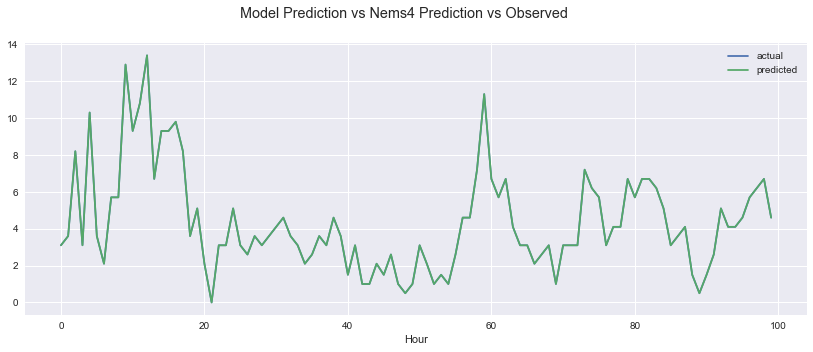

In [130]:
import matplotlib.pyplot as plt

s_actual = features['wind_speed'][sequence_offset+row_split+12:]

# plot sample
plot_samples=100
#nems4_lookahead=12
#nems4_wind_pred = dataset[['nems4_wind_speed']].shift(nems4_lookahead)
#nems4_wind_pred = nems4_wind_pred[len(y_train):len(y_train)+plot_samples].values


fig = plt.figure(figsize=(14, 5))
fig.suptitle("Model Prediction vs Nems4 Prediction vs Observed")

plt.plot(s_actual.values[:plot_samples], label='actual')
plt.plot(undiff_prediction.values[:plot_samples], label='predicted')
plt.xlabel("Hour")
plt.legend()


### Build the LSTM Model

In [131]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau

def build_model(layers):
    model = Sequential()
    
    model.add(LSTM(
            layers[1],
            input_shape=(None, layers[0]),
            return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[2], return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(layers[3], return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(layers[4], activation="linear"))
    
    model.compile(loss="mse", optimizer=RMSprop(lr=0.002))
    
    print(model.summary())
          
    return model

### Build the Pipeline

In [132]:
from sklearn import pipeline
from sklearn import preprocessing

from keras import layers
from keras import models
from keras import callbacks
from keras.wrappers.scikit_learn import KerasClassifier

def run_network(X_train, y_train, X_test, y_test, layers, epochs = 1, batch_size=512):
    model = build_model(layers)
        
    try:
        history = model.fit(
            X_train, y_train, 
            batch_size=512, 
            epochs=epochs, 
            validation_split=0.1,
            callbacks=[
                TensorBoard(log_dir='/tmp/tensorboard', write_graph=True),
                EarlyStopping(monitor='val_loss', patience=2, mode='auto')
            ])
    except KeyboardInterrupt:
        return model, y_test, 0
    
    predicted = model.predict(X_test)
    
    return model, predicted, history


In [133]:
model, predicted, history = run_network(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    layers=[X_train.shape[2], 60, 60, 60, y_train.shape[1]],
    epochs=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 60)          16560     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 60)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 60)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 122       
Total para

In [134]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predicted)

mse

0.61389628770516858

In [143]:
inverse_scale = inverse_scale_prediction(scaler, predicted[:,1], 
                               len(scaled.columns), scaled.columns.get_loc("prediction_12"))

print(mean_squared_error(features['prediction_12'][sequence_offset+row_split:], inverse_scale))


undiff_prediction = inverse_prediction_difference(inverse_scale, 
                                                  features['wind_speed'][sequence_offset+row_split:])

print(mean_squared_error(features['wind_speed'][sequence_offset+row_split+12:], undiff_prediction[:-12]))


3.62585433698
3.62488414655


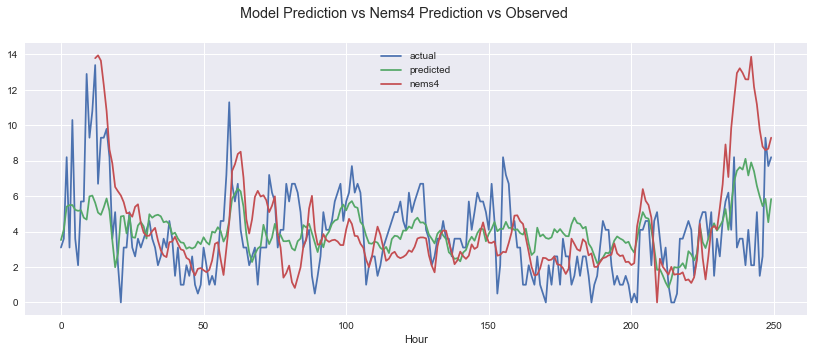

In [144]:
import matplotlib.pyplot as plt

s_actual = features['wind_speed'][sequence_offset+row_split+12:]

# plot sample
plot_samples=250
nems4_lookahead=12
nems4_wind_pred = features['nems4_wind_speed'][sequence_offset+row_split+12:].shift(nems4_lookahead)


fig = plt.figure(figsize=(14, 5))
fig.suptitle("Model Prediction vs Nems4 Prediction vs Observed")

plt.plot(s_actual.values[:plot_samples], label='actual')
plt.plot(undiff_prediction.values[:plot_samples], label='predicted')
plt.plot(nems4_wind_pred.values[:plot_samples], label='nems4')
plt.xlabel("Hour")
plt.legend()
